In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/tiny-imagenet-200.zip

Streaming output truncated to the last 5000 lines.
  inflating: tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9969.JPEG  
  inflating: tiny-ima

In [ ]:
import time
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 123
learning_rate = 0.01
num_epochs = 10
batch_size = 128

# Architecture
num_classes = 200
text_file = '/content/tiny-imagenet-200/wnids.txt'
word_to_num = {}

with open(text_file, 'r') as f:
    text = f.read()
    words = text.split()
    for word in words:
        if word not in word_to_num:
            num_label = len(word_to_num)
            word_to_num[word] = num_label

print(word_to_num)

{'n02124075': 0, 'n04067472': 1, 'n04540053': 2, 'n04099969': 3, 'n07749582': 4, 'n01641577': 5, 'n02802426': 6, 'n09246464': 7, 'n07920052': 8, 'n03970156': 9, 'n03891332': 10, 'n02106662': 11, 'n03201208': 12, 'n02279972': 13, 'n02132136': 14, 'n04146614': 15, 'n07873807': 16, 'n02364673': 17, 'n04507155': 18, 'n03854065': 19, 'n03838899': 20, 'n03733131': 21, 'n01443537': 22, 'n07875152': 23, 'n03544143': 24, 'n09428293': 25, 'n03085013': 26, 'n02437312': 27, 'n07614500': 28, 'n03804744': 29, 'n04265275': 30, 'n02963159': 31, 'n02486410': 32, 'n01944390': 33, 'n09256479': 34, 'n02058221': 35, 'n04275548': 36, 'n02321529': 37, 'n02769748': 38, 'n02099712': 39, 'n07695742': 40, 'n02056570': 41, 'n02281406': 42, 'n01774750': 43, 'n02509815': 44, 'n03983396': 45, 'n07753592': 46, 'n04254777': 47, 'n02233338': 48, 'n04008634': 49, 'n02823428': 50, 'n02236044': 51, 'n03393912': 52, 'n07583066': 53, 'n04074963': 54, 'n01629819': 55, 'n09332890': 56, 'n02481823': 57, 'n03902125': 58, 'n0340

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, random_split
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, root_dir,word_to_num, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.word_to_num = word_to_num
        self.img_paths = []
        self.labels = []
        
        # for label in os.listdir(root_dir):
        #     label_dir = os.path.join(root_dir, label)
        #     if not os.path.isdir(label_dir):
        #         continue
        #     for img_name in os.listdir(label_dir):
        #         img_path = os.path.join(label_dir, img_name)
        #         self.img_paths.append(img_path)
        #         self.labels.append(label)


        for label in os.listdir(root_dir):
            label_dir = os.path.join(root_dir, label)
            if not os.path.isdir(label_dir):
                continue
            for img_dir in os.listdir(label_dir):
              if(img_dir=='images'):
                img_dir= os.path.join(label_dir, img_dir)
                for img_name in os.listdir(img_dir):
                    img_path = os.path.join(img_dir, img_name)
                    self.img_paths.append(img_path)
                    #print(self.word_to_num[label])
                    #print("heh")
                    self.labels.append(self.word_to_num[label])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label


In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
   
    transforms.ToTensor(),
])

dataset = ImageDataset(root_dir='/content/tiny-imagenet-200/train', word_to_num=word_to_num,transform=transform)
train_data, test_data = random_split(dataset, [80000, 20000])

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader= torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)


In [ ]:
from math import e
i=0
for images, labels in train_loader:  
 if(i<100):
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels)
    i=i+1
 else:
   break


Image batch dimensions: torch.Size([64, 1, 64, 64])
Image label dimensions: tensor([178, 120,  20, 136, 115, 157, 164,  84,  31, 186,  47, 185,  28,  47,
        129,  10,  74, 121,  67,  29,  91,  77,  97,   1,  59,  25, 103, 102,
          5, 148,  98, 123, 125,  74, 192,  34,  48,  44, 129, 134, 198, 143,
        179, 176, 158,  10, 184, 166, 181, 165,  12,  39,  43,  43, 159, 167,
         94, 198,  70,  55,  72, 123,  59, 115])
Image batch dimensions: torch.Size([64, 1, 64, 64])
Image label dimensions: tensor([ 90,  77,  90, 180,  64, 128, 120,  26,  27, 159, 175, 161,  87, 187,
          8, 183,  84, 187,  69, 143,  69,  31, 129, 189,  75,  86, 102,  22,
        144, 199,  43, 153,  44, 161,   5,  80,  26,  58,  99, 167,   1, 199,
        125, 168,  46,   8, 183,  63, 100, 150, 187,  49,  15, 142, 122, 183,
         52,   0, 186, 167, 184, 195,  63, 196])
Image batch dimensions: torch.Size([64, 1, 64, 64])
Image label dimensions: tensor([196, 194, 193, 149, 194, 179,  30, 169, 10

In [ ]:
num_classes=200

In [ ]:
class Block(nn.Module):

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
class Res(nn.Module):
    class Block(nn.Module):

        def __init__(self, inplanes, planes, stride=1, downsample=None):
            super().__init__()
            self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                        padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.relu = nn.ReLU(inplace=True)
            self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                        padding=1, bias=False)
            self.bn2 = nn.BatchNorm2d(planes)
            self.downsample = downsample
            self.stride = stride

        def forward(self, x):
            identity = x
            out = self.conv1(x)
            out = self.bn1(out)
            out = self.relu(out)

            out = self.conv2(out)
            out = self.bn2(out)

            if self.downsample is not None:
                identity = self.downsample(x)

            out += identity
            out = self.relu(out)

            return out

    def __init__(self, block, inplane, num_classes=200):
        super().__init__()
        
        self.inplanes = inplane
        self.layer1num=2
        self.layer2num=2
        self.layer3num=2
        self.layer4num=2

        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self.layer(block, 64, self.layer1num)

        
        self.layer2 = self.layer(block, 128, self.layer2num, stride=2)
        self.layer3 = self.layer(block, 256, self.layer3num, stride=2)
        self.layer4 = self.layer(block, 512, self.layer4num, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(512 , num_classes)


    def layer(self, block, planes, blocks, stride=1):
        downsample = None

        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes),
            )

        layers = [block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes

        layers += [block(self.inplanes, planes) for _ in range(1, 2)]
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)          
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)        

        x = self.layer1(x)          
        x = self.layer2(x)          
        x = self.layer3(x)          
        x = self.layer4(x)          

        x = self.avgpool(x)        
        x = torch.flatten(x, 1) 
           
        x = self.fc(x)

        return x

In [ ]:
class Res(nn.Module):

    def __init__(self, block, inplane, num_classes=200):
        super().__init__()
        
        self.inplanes = inplane
        self.layer1num=2
        self.layer2num=2
        self.layer3num=2
        self.layer4num=2

        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self.layer(block, 64, self.layer1num)
        self.layer2 = self.layer(block, 128, self.layer2num, stride=2)
        self.layer3 = self.layer(block, 256, self.layer3num, stride=2)
        self.layer4 = self.layer(block, 512, self.layer4num, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(512 , num_classes)


    def layer(self, block, planes, blocks, stride=1):
        downsample = None

        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes),
            )

        layers = [block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes

        layers += [block(self.inplanes, planes) for _ in range(1, blocks)]
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)          
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)        

        x = self.layer1(x)          
        x = self.layer2(x)          
        x = self.layer3(x)          
        x = self.layer4(x)          

        x = self.avgpool(x)        
        x = torch.flatten(x, 1) 
           
        x = self.fc(x)

        return x

In [ ]:
def resnet18():
    i=64
    model = Res(Block, 64,200)
    return model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
model=resnet18()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
model.to(device)

Res(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): 

In [ ]:
from torchsummary import summary
summary(model, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,136
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
            Block-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

In [ ]:

from torchsummary import summary
summary(model, (1, 64, 64))

In [ ]:
def log_softmax(x):
    max_val = torch.max(x, dim=-1, keepdim=True)[0]
    numerator = torch.exp(x - max_val)
    denominator = torch.sum(numerator, dim=-1, keepdim=True)
    return x - max_val - torch.log(denominator)

In [ ]:
import torch

def nll(input, target):
    batch_size = target.shape[0]
  
    loss_per_sample = torch.zeros(batch_size, dtype=input.dtype, device=input.device)
   
    for i in range(batch_size):
        
        loss_per_sample[i] = -input[i, target[i]]
    
    loss = torch.mean(loss_per_sample)
    return loss


In [ ]:


def closs(output,target):
  pred = log_softmax(output)
  loss = nll(pred, target)
  return loss



In [ ]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):            
        features = features.to(device)
        targets = targets.to(device)
        logits = model(features)
        _, predicted_labels = torch.max(logits, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


start_time = time.time()
train_losses=[]
test_losses = []
train_acc = []
val_acc = []
for epoch in range(18):
    r=0.0
    correct_train = 0
    total_train = 0
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
        targets = targets.to(device)
        
        ### FORWARD AND BACK PROP
        logits = model(features)
        cost = closs(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        optimizer.step()
        r=r+cost.item()
        r /= len(train_loader)
        
        ### UPDATE MODEL PARAMETERS
        
    
        _, predicted = torch.max(logits.data, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()
        ### LOGGING
        if not batch_idx % 250:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
            
    train_losses.append(r) 
    train_acc.append(100 * correct_train / total_train)
    #val_acc.append(test(model, test_loader))
    test_loss = 0   
    correct = 0
    total = 0 
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to(device))
            loss = torch.nn.functional.cross_entropy(output, target.to(device))
            test_loss += loss.item()
            _, predicted = torch.max(logits.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        
    val_acc.append(100 * correct/ total)
    test_loss /= len(test_loader)
    test_losses.append(test_loss)  

    model = model.eval() # eval mode to prevent upd. batchnorm params during inference
    
    print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
              epoch+1, num_epochs, 
              100 * correct_train / total_train))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 000/1250 | Cost: 5.4541
Epoch: 001/010 | Batch 250/1250 | Cost: 5.2737
Epoch: 001/010 | Batch 500/1250 | Cost: 5.3031
Epoch: 001/010 | Batch 750/1250 | Cost: 5.2064
Epoch: 001/010 | Batch 1000/1250 | Cost: 4.9120
Epoch: 001/010 training accuracy: 1.54%
Time elapsed: 1.74 min
Epoch: 002/010 | Batch 000/1250 | Cost: 4.8092
Epoch: 002/010 | Batch 250/1250 | Cost: 4.4988
Epoch: 002/010 | Batch 500/1250 | Cost: 4.4827
Epoch: 002/010 | Batch 750/1250 | Cost: 4.1311
Epoch: 002/010 | Batch 1000/1250 | Cost: 4.2417
Epoch: 002/010 training accuracy: 7.45%
Time elapsed: 3.45 min
Epoch: 003/010 | Batch 000/1250 | Cost: 4.0465
Epoch: 003/010 | Batch 250/1250 | Cost: 3.6696
Epoch: 003/010 | Batch 500/1250 | Cost: 4.0313
Epoch: 003/010 | Batch 750/1250 | Cost: 3.7277
Epoch: 003/010 | Batch 1000/1250 | Cost: 3.9326
Epoch: 003/010 training accuracy: 13.14%
Time elapsed: 5.15 min
Epoch: 004/010 | Batch 000/1250 | Cost: 3.8839
Epoch: 004/010 | Batch 250/1250 | Cost: 4.0489
Epoch: 0

In [ ]:

train_losses = [x * 64 for x in train_losses]

In [ ]:
len(train_losses)

18

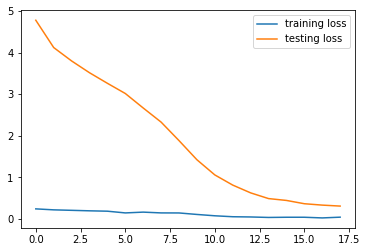

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='testing loss')
plt.legend()
plt.show()

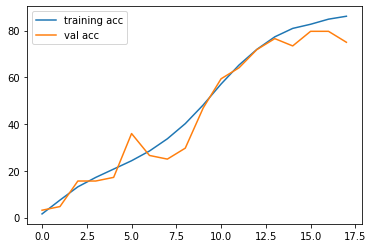

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_acc, label='training acc')
plt.plot(val_acc, label='val acc')
plt.legend()
plt.show()

In [ ]:
import torch
import torch.nn.functional as F

# assume model is a PyTorch model
# assume data_loader is a PyTorch data loader

# set the model to evaluation mode
model.eval()

correct_top5 = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(device))
        _, pred = outputs.topk(k=5, dim=1)  # get top 5 predictions
        pred = pred.t()  # transpose the tensor
        correct = pred.eq(labels.to(device).reshape(1, -1).expand_as(pred))  # check if the predictions match the labels
        correct_top5 += correct[:5].reshape(-1).float().sum(0, keepdim=True)  # count how many top-5 predictions are correct
        total += labels.size(0)

# calculate top-5 accuracy
top5_acc = (correct_top5 / total) * 100

print('Top-5 accuracy of the model: {:.2f}%'.format(top5_acc.item()))

Top-5 accuracy of the model: 99.71%


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


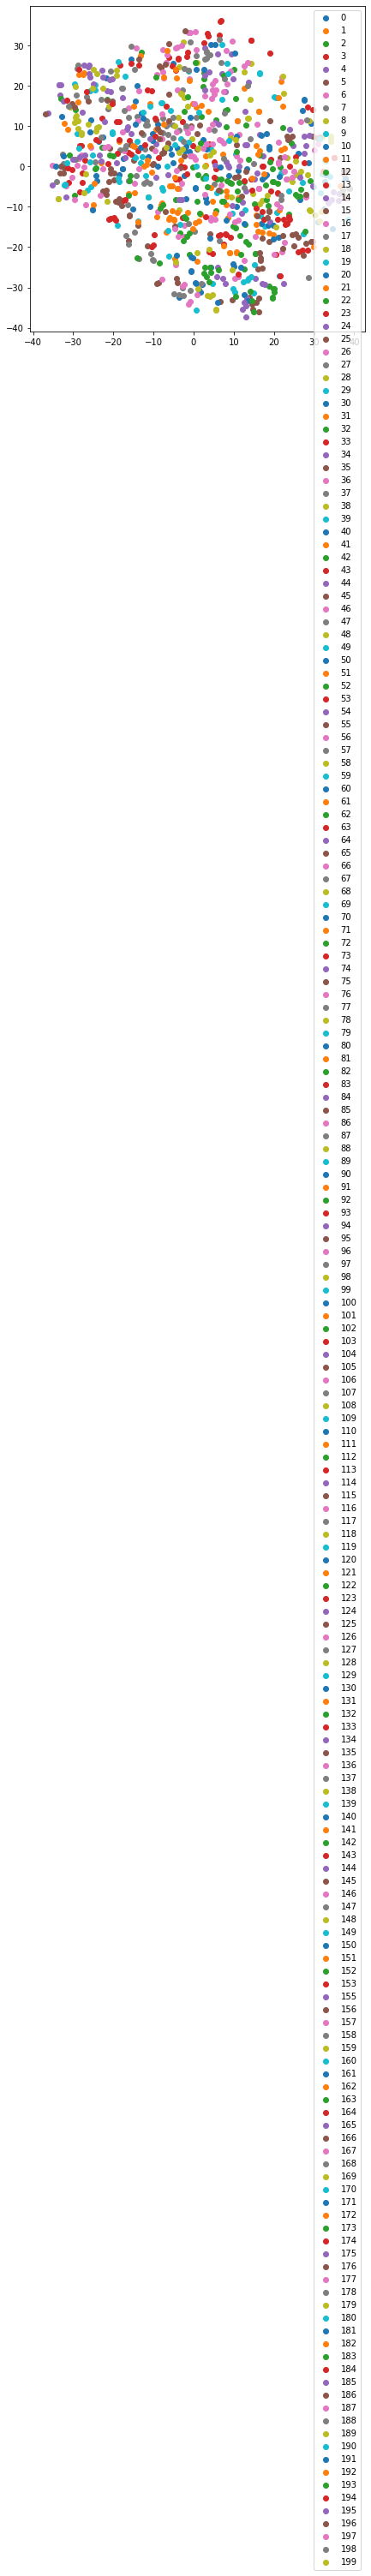

In [ ]:
lt_embed = []
lt_lb = []
ln = 0 
with torch.no_grad():
  for img, lb in test_loader:
    embed =  model(img.to(device))
    lt_embed.append(embed.cpu())
    lt_lb.append(lb)
    ln+=len(img)
    if(ln>=1000):
      break
embed_tensor = torch.cat(lt_embed)
label_tensor = torch.cat(lt_lb) 
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
tsne_data = tsne.fit_transform(embed_tensor) 

import numpy as np
scatter_x = tsne_data[:,0]
scatter_y = tsne_data[:,1]
group = label_tensor

fig, ax = plt.subplots(figsize=(7, 7))
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix],  label = g)
ax.legend()
plt.show()

In [ ]:
print("f")

f


# center loss


In [ ]:
model=resnet18()

In [ ]:
import torch
import torch.nn as nn
class CenterLoss(nn.Module):
   
    def __init__(self, device):
        super(CenterLoss, self).__init__()
        self.num_classes = 200
        self.feat_dim = 64*64
        self.LAMBDA=10
        self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).to(device))

    def new_loss(self,x,labels):
       
          dist = torch.cdist(x, self.centers) ** 2
          mask = torch.nn.functional.one_hot(labels, self.num_classes).to(x.device)
          dist = dist * mask.float()
          loss = self.LAMBDA*dist.clamp(min=1e-12, max=1e+12).sum() / x.size(0)
          return loss   

    def forward(self, x, labels):
        loss=self.new_loss(x,labels)
        return loss

In [ ]:
center_loss = CenterLoss(device)
params = list(model.parameters()) + list(center_loss.parameters())
optimizer = torch.optim.SGD(params, lr=0.1)
model = torch.jit.script(model).to(device)
criterion = torch.jit.script(center_loss)

In [ ]:
alpha=0.001

start_time = time.time()
train_losses=[]
test_losses = []
train_acc = []
val_acc = []
for epoch in range(13):
    r=0.0
    correct_train = 0
    total_train = 0
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
        targets = targets.to(device)
        
        ### FORWARD AND BACK PROP
        logits = model(features)
        cost = closs(logits, targets)
        loss = center_loss(features.reshape(64,64*64), targets) * alpha + cost
        optimizer.zero_grad()
        loss.backward()
        for param in center_loss.parameters():
            # lr_cent is learning rate for center loss, e.g. lr_cent = 0.5
            param.grad.data *= (0.5 / (alpha * 0.1))
        optimizer.step()
        
        r=r+cost.item()
        r /= len(train_loader)
        
        ### UPDATE MODEL PARAMETERS
        
    
        _, predicted = torch.max(logits.data, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()
        ### LOGGING
        if not batch_idx % 250:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
            
    train_losses.append(r) 
    train_acc.append(100 * correct_train / total_train)
    #val_acc.append(test(model, test_loader))
    test_loss = 0   
    correct = 0
    total = 0 
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to(device))
            loss = torch.nn.functional.cross_entropy(output, target.to(device))
            test_loss += loss.item()
            _, predicted = torch.max(logits.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        
    val_acc.append(100 * correct/ total)
    test_loss /= len(test_loader)
    test_losses.append(test_loss)  

    model = model.eval() # eval mode to prevent upd. batchnorm params during inference
    
    print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
              epoch+1, num_epochs, 
              100 * correct_train / total_train))



Epoch: 001/010 | Batch 000/1250 | Cost: 5.4354
Epoch: 001/010 | Batch 250/1250 | Cost: 4.8729
Epoch: 001/010 | Batch 500/1250 | Cost: 4.5347
Epoch: 001/010 | Batch 750/1250 | Cost: 4.6141
Epoch: 001/010 | Batch 1000/1250 | Cost: 4.4241
Epoch: 001/010 training accuracy: 7.16%
Epoch: 002/010 | Batch 000/1250 | Cost: 3.8089
Epoch: 002/010 | Batch 250/1250 | Cost: 4.0071
Epoch: 002/010 | Batch 500/1250 | Cost: 3.6485
Epoch: 002/010 | Batch 750/1250 | Cost: 3.5760
Epoch: 002/010 | Batch 1000/1250 | Cost: 3.4087
Epoch: 002/010 training accuracy: 15.85%
Epoch: 003/010 | Batch 000/1250 | Cost: 3.6493
Epoch: 003/010 | Batch 250/1250 | Cost: 3.1867
Epoch: 003/010 | Batch 500/1250 | Cost: 3.6469
Epoch: 003/010 | Batch 750/1250 | Cost: 3.3989
Epoch: 003/010 | Batch 1000/1250 | Cost: 2.9001
Epoch: 003/010 training accuracy: 21.85%
Epoch: 004/010 | Batch 000/1250 | Cost: 3.1035
Epoch: 004/010 | Batch 250/1250 | Cost: 2.8398
Epoch: 004/010 | Batch 500/1250 | Cost: 3.1911
Epoch: 004/010 | Batch 750/12

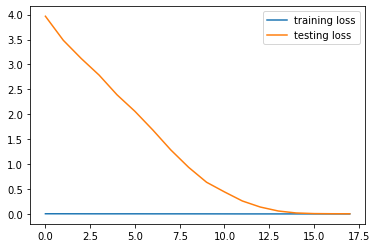

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='testing loss')
plt.legend()
plt.show()

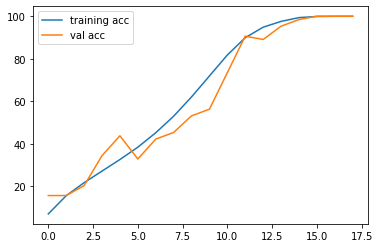

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_acc, label='training acc')
plt.plot(val_acc, label='val acc')
plt.legend()
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


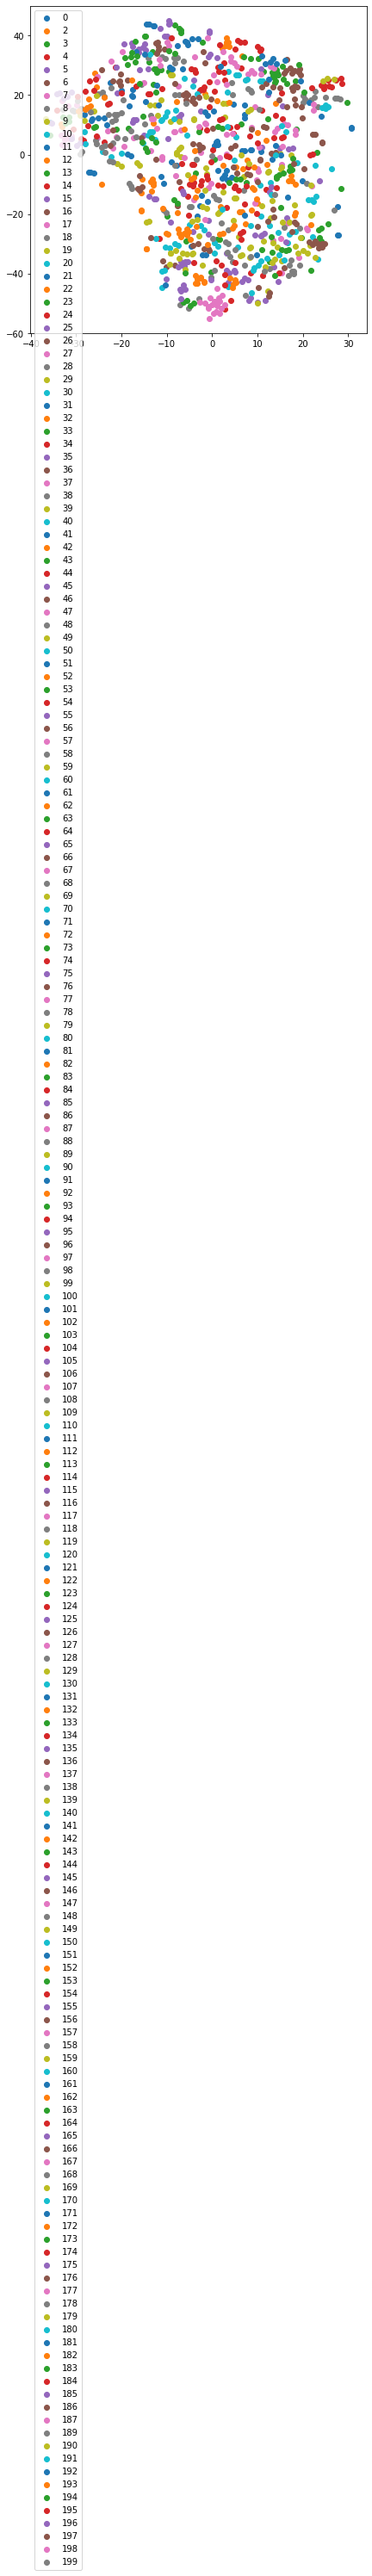

In [ ]:
import matplotlib.pyplot as plt

lt_embed = []
lt_lb = []
ln = 0 
with torch.no_grad():
  for img, lb in test_loader:
    embed =  model(img.to(device))
    lt_embed.append(embed.cpu())
    lt_lb.append(lb)
    ln+=len(img)
    if(ln>=1000):
      break
embed_tensor = torch.cat(lt_embed)
label_tensor = torch.cat(lt_lb) 
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
tsne_data = tsne.fit_transform(embed_tensor) 

import numpy as np
scatter_x = tsne_data[:,0]
scatter_y = tsne_data[:,1]
group = label_tensor

fig, ax = plt.subplots(figsize=(7, 7))
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix],  label = g)
ax.legend()
plt.show()

In [ ]:
import torch
import torch.nn.functional as F

# assume model is a PyTorch model
# assume data_loader is a PyTorch data loader

# set the model to evaluation mode
model.eval()

correct_top5 = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(device))
        _, pred = outputs.topk(k=5, dim=1)  # get top 5 predictions
        pred = pred.t()  # transpose the tensor
        correct = pred.eq(labels.to(device).reshape(1, -1).expand_as(pred))  # check if the predictions match the labels
        correct_top5 += correct[:5].reshape(-1).float().sum(0, keepdim=True)  # count how many top-5 predictions are correct
        total += labels.size(0)

# calculate top-5 accuracy
top5_acc = (correct_top5 / total) * 100                                                                                                                                                                                                                                     -.01

print('Top-5 accuracy of the model: {:.2f}%'.format(top5_acc.item()))

Top-5 accuracy of the model: 99.97%


In [ ]:
features.reshape(64,64*64)

tensor([[0.9098, 0.2706, 0.2196,  ..., 0.2549, 0.2549, 0.2706],
        [0.5843, 0.5412, 0.5412,  ..., 0.0627, 0.0196, 0.0588],
        [0.4902, 0.4902, 0.4902,  ..., 0.7843, 0.8039, 0.7843],
        ...,
        [0.6392, 0.6392, 0.6392,  ..., 0.3176, 0.1961, 0.2784],
        [0.4549, 0.4392, 0.3843,  ..., 0.6000, 0.5686, 0.6078],
        [0.2431, 0.2431, 0.3059,  ..., 0.6353, 0.6118, 0.6588]],
       device='cuda:0')

# Triplet loss


In [ ]:
train_loader

In [ ]:
from math import e
i=0
for images, labels in train_loader:  
 if(i<3):
    print('Image dimensions:', images.shape)
    print('Image dimensions:', labels.shape)
    i=i+1
 else:
   break

Image dimensions: torch.Size([64, 1, 64, 64])
Image dimensions: torch.Size([64])
Image dimensions: torch.Size([64, 1, 64, 64])
Image dimensions: torch.Size([64])
Image dimensions: torch.Size([64, 1, 64, 64])
Image dimensions: torch.Size([64])


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
random_seed = 123
learning_rate = 0.01
num_epochs = 10
batch_size = 64

# Architecture
num_classes = 200

In [ ]:
model=resnet18()
optimizer = torch.optim.SGD(model.parameters(), learning_rate)
model.to(device)

Res(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.lamb = 0.00001

    def _pairwise_distances(self,embeddings):
        
        squared=False
        
        dot_product = torch.matmul(embeddings, embeddings.t())
        
        square_norm = torch.diag(dot_product)

        distances = torch.unsqueeze(square_norm, 0) - 2.0 * dot_product + torch.unsqueeze(square_norm, 1)

        distances = torch.clamp(distances, 0.0)

        if not squared:
            
            mask = torch.eq(distances, 0.0).float()
            distances = distances + mask * 1e-16

            distances = torch.sqrt(distances)

            distances = distances * (1.0 - mask)

        return distances

    def _get_anchor_negative_triplet_mask(self,labels):
       
        labels_equal = torch.eq(torch.unsqueeze(labels, 0), torch.unsqueeze(labels, 1))

        mask = torch.logical_not(labels_equal)

        return mask  

    def _get_anchor_positive_triplet_mask(self,labels):
     
        indices_equal = torch.eye(labels.size(0), dtype=torch.bool)
        indices_not_equal = torch.logical_not(indices_equal)
        indices_not_equal=indices_not_equal.to(self.device)

        labels_equal = torch.eq(torch.unsqueeze(labels, 1), torch.unsqueeze(labels, 0))

        mask = torch.logical_and(indices_not_equal, labels_equal)
    
        return mask

    

    def _get_triplet_mask(self,labels):

        indices_equal = torch.eye(labels.size(0)).bool()
        indices_not_equal = ~indices_equal
        i_not_equal_j = indices_not_equal.unsqueeze(2)
        i_not_equal_k = indices_not_equal.unsqueeze(1)
        j_not_equal_k = indices_not_equal.unsqueeze(0)

        distinct_indices = i_not_equal_j & i_not_equal_k & j_not_equal_k

        label_equal = labels.unsqueeze(0) == labels.unsqueeze(1)
        i_equal_j = label_equal.unsqueeze(2)
        i_equal_k = label_equal.unsqueeze(1)

        valid_labels = i_equal_j & ~i_equal_k

        mask = distinct_indices & valid_labels

        return mask

    
    def batch_hard_triplet_loss(self,labels, embeddings):
       
        squared=False
        pairwise_dist = self._pairwise_distances(embeddings)
        mask_anchor_positive = self._get_anchor_positive_triplet_mask(labels)
        mask_anchor_positive = mask_anchor_positive.float()

        anchor_positive_dist = mask_anchor_positive * pairwise_dist
        hardest_positive_dist, _ = torch.max(anchor_positive_dist, dim=1, keepdim=True)
        torch.mean(hardest_positive_dist)

        mask_anchor_negative = self._get_anchor_negative_triplet_mask(labels)
        mask_anchor_negative = mask_anchor_negative.float()
        max_anchor_negative_dist, _ = torch.max(pairwise_dist, dim=1, keepdim=True)

        anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (1.0 - mask_anchor_negative)
        hardest_negative_dist, _ = torch.min(anchor_negative_dist, dim=1, keepdim=True)
        torch.mean(hardest_negative_dist)


        triplet_loss = torch.max(hardest_positive_dist - hardest_negative_dist + self.margin, torch.tensor(0.0))
        triplet_loss = torch.mean(triplet_loss)

        return triplet_loss  

    def return_loss(self, embeddings: torch.Tensor, labels :torch.Tensor):
        
        loss=self.batch_hard_triplet_loss(labels,embeddings,)
        return loss

    
    def forward(self, embeddings: torch.Tensor, labels :torch.Tensor ) -> torch.Tensor:
        
        loss=self.return_loss(embeddings,labels)
        return loss*self.lamb

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
model = torch.jit.script(model).to(device)
criterion = torch.jit.script(TripletLoss())

In [ ]:
train_losses=[]
test_losses = []
train_acc = []
val_acc = []

for epoch in range(18):
    r=0.0
    correct_train = 0
    total_train = 0
    model = model.train()
    for image, label in train_loader:
        image=image.to(device)
        label=label.to(device)

        optimizer.zero_grad()
        embedding=model(image)

        loss = criterion(embedding, label)                                                                                                                                                                                                             +closs(embedding, label)
        loss.backward()
        optimizer.step()
        
        
        r=r+loss.item()
        r /= len(train_loader)
        
        ### UPDATE MODEL PARAMETERS
        
    
        _, predicted = torch.max(embedding.data, 1)
        total_train += label.size(0)
        correct_train += (predicted == label).sum().item()
                    
            
    train_losses.append(r) 

    train_acc.append(100 * correct_train / total_train)
    #val_acc.append(test(model, test_loader))
    test_loss = 0   
    correct = 0
    total = 0 
    with torch.no_grad():
        for image, label in test_loader:
            image=image.to(device)
            label=label.to(device)
            optimizer.zero_grad()
            embedding=model(image)

            loss = criterion(embedding, label)
            test_loss += loss.item()
            _, predicted = torch.max(embedding.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
        
    val_acc.append(100 * correct/ total)
    test_loss /= len(test_loader)
    test_losses.append(test_loss)  

    model = model.eval() # eval mode to prevent upd. batchnorm params during inference
    
    print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
              epoch+1, num_epochs, 
              100 * correct_train / total_train))
    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, 10,r))

/usr/local/lib/python3.8/dist-packages/torch/autograd/__init__.py:197: UserWarning: operator() profile_node %482 : int[] = prim::profile_ivalue(%480)
 does not have profile information (Triggered internally at ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:105.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 001/010 training accuracy: 1.45%
Epoch: 1/10 - Loss: 0.0038
Epoch: 002/010 training accuracy: 7.61%
Epoch: 2/10 - Loss: 0.0030
Epoch: 003/010 training accuracy: 13.40%
Epoch: 3/10 - Loss: 0.0028
Epoch: 004/010 training accuracy: 17.23%
Epoch: 4/10 - Loss: 0.0028
Epoch: 005/010 training accuracy: 20.90%
Epoch: 5/10 - Loss: 0.0023
Epoch: 006/010 training accuracy: 24.90%
Epoch: 6/10 - Loss: 0.0026
Epoch: 007/010 training accuracy: 29.19%
Epoch: 7/10 - Loss: 0.0026
Epoch: 008/010 training accuracy: 34.63%
Epoch: 8/10 - Loss: 0.0020
Epoch: 009/010 training accuracy: 41.34%
Epoch: 9/10 - Loss: 0.0019
Epoch: 010/010 training accuracy: 49.95%
Epoch: 10/10 - Loss: 0.0018
Epoch: 011/010 training accuracy: 58.59%
Epoch: 11/10 - Loss: 0.0014
Epoch: 012/010 training accuracy: 67.42%
Epoch: 12/10 - Loss: 0.0010
Epoch: 013/010 training accuracy: 73.62%
Epoch: 13/10 - Loss: 0.0009
Epoch: 014/010 training accuracy: 78.23%
Epoch: 14/10 - Loss: 0.0008
Epoch: 015/010 training accuracy: 81.38%
Epoc

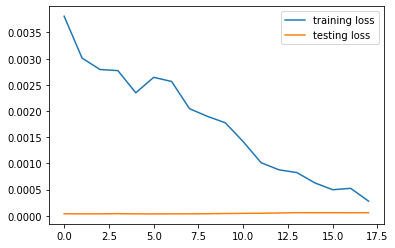

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='testing loss')
plt.legend()
plt.show()

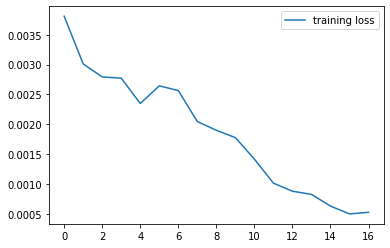

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses[:-1] ,label='training loss')
plt.legend()
plt.show()

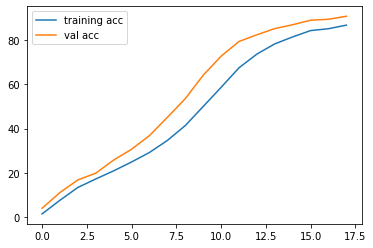

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_acc, label='training acc')
plt.plot(val_acc, label='val acc')
plt.legend()
plt.show()

In [ ]:
import torch
import torch.nn.functional as F

model.eval()

correct_top5 = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(device))
        _, pred = outputs.topk(k=5, dim=1)  
        pred = pred.t()  # transpose the tensor
        correct = pred.eq(labels.to(device).reshape(1, -1).expand_as(pred))  
        correct_top5 += correct[:5].reshape(-1).float().sum(0, keepdim=True)  # count how many top-5 predictions are correct
        total += labels.size(0)

# calculate top-5 accuracy
top5_acc = (correct_top5 / total) * 100

print('Top-5 accuracy of the model: {:.2f}%'.format(top5_acc.item()))

Top-5 accuracy of the model: 99.70%


# Greedy Layer wise training 

In [ ]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
import torch.nn as nn
from torchvision import datasets, transforms
import numpy as np
#plotting and visualization library
import matplotlib.pyplot as plt
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim,reshape):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
         
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
            nn.BatchNorm1d(input_dim),
          
        )
        self.reshape=reshape

    def forward(self, x):
        x=x.view(-1,self.reshape)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Define transforms for the dataset
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((96, 96)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the STL-10 dataset
train_dataset = datasets.STL10(root='./data', split='train', download=True, transform=transform)
test_dataset = datasets.STL10(root='./data', split='test', download=True, transform=transform)

# Create data loaders for the dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [ ]:
input_dim = 96*96
hidden_dims = [1024,1000,500,256, 128,64]
output_dim = 10
num_epochs = 10
learning_rate = 0.001
criterion = nn.MSELoss()

In [ ]:
autoencoder1 = Autoencoder(input_dim, hidden_dims[0],96*96)
optimizer1 = optim.Adam(autoencoder1.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(3):
    running_loss = 0.0
    for data in train_loader:
        img, _ = data
        optimizer1.zero_grad()
        output = autoencoder1(img)
        loss = criterion(output, img.view(-1,96*96))
        loss.backward()
        running_loss += loss.item()
        optimizer1.step()
    print("Epoch {} - Training loss: {:.4f}".format(epoch+1, running_loss/len(train_loader)))
   

Epoch 1 - Training loss: 0.5207
Epoch 2 - Training loss: 0.3279
Epoch 3 - Training loss: 0.2354


In [ ]:
autoencoder2 = Autoencoder(hidden_dims[0], hidden_dims[1],1024)
optimizer2 = optim.Adam(autoencoder2.parameters(), lr=learning_rate)

for epoch in range(3):
    running_loss = 0.0
    for data in train_loader:
        img, _ = data
        optimizer2.zero_grad()
        input=autoencoder1.encoder(img.view(-1,96*96))
        output = autoencoder2(input)
        loss = criterion(output, input)
        loss.backward()
        running_loss += loss.item()
        optimizer2.step()
    print("Epoch {} - Training loss: {:.4f}".format(epoch+1, running_loss/len(train_loader)))

Epoch 1 - Training loss: 0.1758
Epoch 2 - Training loss: 0.0296
Epoch 3 - Training loss: 0.0217


In [ ]:
autoencoder3 = Autoencoder(hidden_dims[1], hidden_dims[2],hidden_dims[1])
optimizer3 = optim.Adam(autoencoder3.parameters(), lr=learning_rate)

for epoch in range(3):
    running_loss = 0.0
    for data in train_loader:
        img, _ = data
        optimizer3.zero_grad()
        input=autoencoder2.encoder(autoencoder1.encoder(img.view(-1,96*96)))
        output = autoencoder3(input)
        loss = criterion(output, input)
        loss.backward()
        running_loss += loss.item()
        optimizer3.step()
    print("Epoch {} - Training loss: {:.4f}".format(epoch+1, running_loss/len(train_loader)))


Epoch 1 - Training loss: 0.2483
Epoch 2 - Training loss: 0.0290
Epoch 3 - Training loss: 0.0198


In [ ]:
autoencoder4 = Autoencoder(hidden_dims[2], hidden_dims[3],hidden_dims[2])
optimizer4 = optim.Adam(autoencoder4.parameters(), lr=learning_rate)

for epoch in range(3):
    running_loss = 0.0
    for data in train_loader:
        img, _ = data
        optimizer4.zero_grad()
        input=autoencoder3.encoder(autoencoder2.encoder(autoencoder1.encoder(img.view(-1,96*96))))
        output = autoencoder4(input)
        loss = criterion(output, input)
        loss.backward()
        running_loss += loss.item()
        optimizer4.step()
    print("Epoch {} - Training loss: {:.4f}".format(epoch+1, running_loss/len(train_loader)))

Epoch 1 - Training loss: 0.3466
Epoch 2 - Training loss: 0.0316
Epoch 3 - Training loss: 0.0195


In [ ]:
autoencoder5 = Autoencoder(hidden_dims[3], hidden_dims[4],hidden_dims[3])
optimizer5 = optim.Adam(autoencoder5.parameters(), lr=learning_rate)

for epoch in range(4):
    running_loss = 0.0
    for data in train_loader:
        img, _ = data
        optimizer5.zero_grad()
        input=autoencoder4.encoder(autoencoder3.encoder(autoencoder2.encoder(autoencoder1.encoder(img.view(-1,96*96)))))
        output = autoencoder5(input)
        loss = criterion(output, input)
        loss.backward()
        running_loss += loss.item()
        optimizer5.step()
    print("Epoch {} - Training loss: {:.4f}".format(epoch+1, running_loss/len(train_loader)))

Epoch 1 - Training loss: 0.5715
Epoch 2 - Training loss: 0.0736
Epoch 3 - Training loss: 0.0319
Epoch 4 - Training loss: 0.0224


In [ ]:
autoencoder6 = Autoencoder(hidden_dims[4], hidden_dims[5],hidden_dims[4])
optimizer6 = optim.Adam(autoencoder6.parameters(), lr=learning_rate)

for epoch in range(5):
    running_loss = 0.0
    for data in train_loader:
        img, _ = data
        optimizer6.zero_grad()
        input=autoencoder5.encoder(autoencoder4.encoder(autoencoder3.encoder(autoencoder2.encoder(autoencoder1.encoder(img.view(-1,96*96))))))
        output = autoencoder6(input)
        loss = criterion(output, input)
        loss.backward()
        running_loss += loss.item()
        optimizer6.step()
    print("Epoch {} - Training loss: {:.4f}".format(epoch+1, running_loss/len(train_loader)))

Epoch 1 - Training loss: 0.8507
Epoch 2 - Training loss: 0.2321
Epoch 3 - Training loss: 0.1155
Epoch 4 - Training loss: 0.0691
Epoch 5 - Training loss: 0.0486


# Fine tuning 

In [ ]:
autoencoder1.encoder

Sequential(
  (0): Linear(in_features=9216, out_features=1024, bias=True)
  (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
autoencoder2.encoder

Sequential(
  (0): Linear(in_features=1024, out_features=1000, bias=True)
  (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
autoencoder3.encoder

Sequential(
  (0): Linear(in_features=1000, out_features=500, bias=True)
  (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
autoencoder4.encoder

Sequential(
  (0): Linear(in_features=500, out_features=256, bias=True)
  (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
autoencoder5.encoder

Sequential(
  (0): Linear(in_features=256, out_features=128, bias=True)
  (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
autoencoder6.encoder

Sequential(
  (0): Linear(in_features=128, out_features=64, bias=True)
  (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
class classifier(nn.Module):
    def __init__(self):
        super(classifier, self).__init__()
        self.l1 = nn.Sequential(
            nn.Linear(9216,1024),
            nn.BatchNorm1d(1024)    
        )
        self.l2 = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.BatchNorm1d(1000)    
        )
        self.l3 = nn.Sequential(
            nn.Linear(1000, 500),
           nn.BatchNorm1d(500)  
        )
        self.l4 = nn.Sequential(
            nn.Linear(500, 256),
            nn.BatchNorm1d(256)  
        )
        self.l5 = nn.Sequential(
           nn.Linear(256, 128),
          nn.BatchNorm1d(128)    
        )
        self.l6 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64) 
        )
        self.l7=nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x=x.view(-1,96*96)
        x = self.l1(x)
        x=self.relu(x)
        

        x = self.l2(x)
        x=self.relu(x)
        #x = self.dropout()

        x = self.l3(x)
        x=self.relu(x)
        

        x = self.l4(x)
        x=self.relu(x)
       

        x = self.l5(x)
        x=self.relu(x)
       # x = self.dropout()

        x = self.l6(x)
        x=self.relu(x)

        x = self.l7(x)
        return x

In [ ]:
clas = classifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clas.parameters(), lr=0.001)

In [ ]:
clas.l1

Sequential(
  (0): Linear(in_features=9216, out_features=1024, bias=True)
  (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
clas.l1.load_state_dict(autoencoder1.encoder.state_dict())

<All keys matched successfully>

In [ ]:
clas.l2.load_state_dict(autoencoder2.encoder.state_dict())
clas.l3.load_state_dict(autoencoder3.encoder.state_dict())
clas.l4.load_state_dict(autoencoder4.encoder.state_dict())
clas.l5.load_state_dict(autoencoder5.encoder.state_dict())
clas.l6.load_state_dict(autoencoder6.encoder.state_dict())

<All keys matched successfully>

In [ ]:

train_losses=[]
test_losses = []
train_acc = []
val_acc = []
for epoch in range(10):
    r=0.0
    correct_train = 0
    total_train = 0
    clas = clas.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        logits = clas(features)
        cost = criterion(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        optimizer.step()
        r=r+cost.item()
        r /= len(train_loader)
        
        ### UPDATE MODEL PARAMETERS
        
    
        _, predicted = torch.max(logits.data, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()
        ### LOGGING
        if not batch_idx % 250:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
            
    train_losses.append(r) 
    train_acc.append(100 * correct_train / total_train)
    #val_acc.append(test(model, test_loader))
    test_loss = 0   
    correct = 0
    total = 0 
    with torch.no_grad():
        for data, target in test_loader:
            output = clas(data)
            loss = torch.nn.functional.cross_entropy(output, target)
            test_loss += loss.item()
            _, predicted = torch.max(logits.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        
    val_acc.append(100 * correct/ total)
    test_loss /= len(test_loader)
    test_losses.append(test_loss)  

    clas = clas.eval() # eval mode to prevent upd. batchnorm params during inference
    
    print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
              epoch+1, num_epochs, 
              100 * correct_train / total_train))


Epoch: 001/010 | Batch 000/079 | Cost: 1.7367
Epoch: 001/010 training accuracy: 36.90%
Epoch: 002/010 | Batch 000/079 | Cost: 1.6760
Epoch: 002/010 training accuracy: 38.64%
Epoch: 003/010 | Batch 000/079 | Cost: 1.5257
Epoch: 003/010 training accuracy: 43.68%
Epoch: 004/010 | Batch 000/079 | Cost: 1.5733
Epoch: 004/010 training accuracy: 44.34%
Epoch: 005/010 | Batch 000/079 | Cost: 1.2534
Epoch: 005/010 training accuracy: 47.16%
Epoch: 006/010 | Batch 000/079 | Cost: 1.3050
Epoch: 006/010 training accuracy: 51.68%
Epoch: 007/010 | Batch 000/079 | Cost: 1.1191
Epoch: 007/010 training accuracy: 53.28%
Epoch: 008/010 | Batch 000/079 | Cost: 1.1366
Epoch: 008/010 training accuracy: 56.72%
Epoch: 009/010 | Batch 000/079 | Cost: 0.9359
Epoch: 009/010 training accuracy: 61.60%
Epoch: 010/010 | Batch 000/079 | Cost: 1.0740
Epoch: 010/010 training accuracy: 60.88%


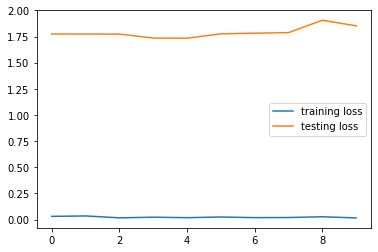

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='testing loss')
plt.legend()
plt.show()

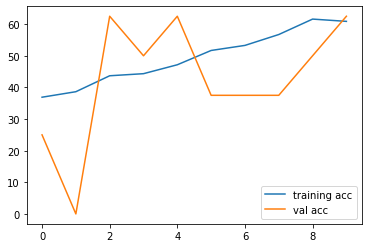

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_acc, label='training acc')
plt.plot(val_acc, label='val acc')
plt.legend()
plt.show()

In [ ]:
from torch.autograd import Variable

In [ ]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images, labels
        test = Variable(images)
        outputs = clas(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(64):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(i, class_correct[i] * 100 / total_correct[i]))

Accuracy of 0: 50.62%
Accuracy of 1: 30.38%
Accuracy of 2: 59.25%
Accuracy of 3: 25.00%
Accuracy of 4: 42.75%
Accuracy of 5: 24.38%
Accuracy of 6: 35.62%
Accuracy of 7: 28.50%
Accuracy of 8: 50.50%
Accuracy of 9: 47.62%


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


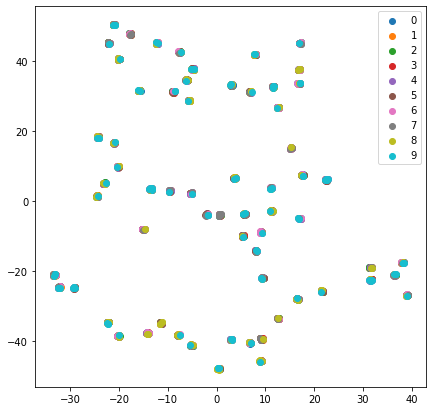

In [ ]:
lt_embed = []
lt_lb = []
ln = 0 
with torch.no_grad():
  for img, lb in test_loader:
    embed = clas.l4(clas.l3(clas.l2(clas.l1(Variable(images.view(64, 1, 96, 96).view(-1,96*96))))))
    lt_embed.append(embed.cpu())
    lt_lb.append(lb)
    ln+=len(img)
    if(ln>=1000):
      break
embed_tensor = torch.cat(lt_embed)
label_tensor = torch.cat(lt_lb) 
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
tsne_data = tsne.fit_transform(embed_tensor) 

import numpy as np
scatter_x = tsne_data[:,0]
scatter_y = tsne_data[:,1]
group = label_tensor

fig, ax = plt.subplots(figsize=(7, 7))
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix],  label = g)
ax.legend()
plt.show()